In [1]:
!pip install xgboost imbalanced-learn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import pickle
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


In [2]:
df = pd.read_csv("/content/audio_features.csv")

print(f"Dataset loaded: {df.shape}")
print(f"\nFirst 3 rows:")
print(df.head(3))
print(f"\nColumns: {df.columns.tolist()}")



Dataset loaded: (32, 34)

First 3 rows:
             filename  augmentation  duration  sample_rate   feature_0  \
0  carine_confirm.wav      original  1.770703        22050 -410.162262   
1  carine_confirm.wav   pitch_shift  1.770703        22050 -440.016632   
2  carine_confirm.wav  time_stretch  1.475601        22050 -433.944946   

   feature_1  feature_2  feature_3  feature_4  feature_5  ...  feature_20  \
0  60.599358  48.061550  -0.949876  26.802389   9.838674  ...   17.445024   
1  68.730370  41.065006  -0.682891  25.279615  -0.457006  ...   15.135699   
2  62.250610  49.122345  -3.365760  26.227173   9.018525  ...   17.746134   

   feature_21  feature_22  feature_23  feature_24  feature_25   feature_26  \
0    7.879996   12.286227    5.678034    7.099344    6.826686  7462.792969   
1    8.239335    9.568310    7.007947    5.443185    9.944477  6990.740412   
2    7.353291   12.308311    5.263170    6.213275    6.750124  7454.189301   

   feature_27  feature_28   feature_29  


In [3]:
df['speaker'] = df['filename'].str.split('_').str[0]

print("\n" + "="*70)
print("DATASET OVERVIEW")
print("="*70)
print(f"Total samples: {len(df)}")
print(f"Total speakers: {df['speaker'].nunique()}")
print(f"\nSpeaker distribution:")
print(df['speaker'].value_counts())
print(f"\nAugmentation distribution:")
print(df['augmentation'].value_counts())



DATASET OVERVIEW
Total samples: 32
Total speakers: 7

Speaker distribution:
speaker
carine                           8
confirm-transaction-best.wav     4
confirm-transaction-david.wav    4
Mike-approve.wav                 4
Mike-confirm.wav                 4
yes-approve-best.wav             4
yes-approve-david.wav            4
Name: count, dtype: int64

Augmentation distribution:
augmentation
original            8
pitch_shift         8
time_stretch        8
background_noise    8
Name: count, dtype: int64


In [7]:
print("\n" + "="*70)
print("FEATURE ENGINEERING")
print("="*70)

# Get all audio feature columns (feature_0, feature_1, etc.)
feature_cols = [col for col in df.columns if col.startswith('feature_')]
print(f"Audio features found: {len(feature_cols)}")

# Create statistical features from audio features
df['feature_mean'] = df[feature_cols].mean(axis=1)
df['feature_std'] = df[feature_cols].std(axis=1)
df['feature_max'] = df[feature_cols].max(axis=1)
df['feature_min'] = df[feature_cols].min(axis=1)
df['feature_range'] = df['feature_max'] - df['feature_min']
df['energy_sum'] = df[feature_cols].abs().sum(axis=1)
df['energy_mean'] = df[feature_cols].abs().mean(axis=1)

# One-hot encode augmentation type
aug_dummies = pd.get_dummies(df['augmentation'], prefix='aug')
df = pd.concat([df, aug_dummies], axis=1)

print(f"✓ Created 7 statistical features")
print(f"✓ Created {len(aug_dummies.columns)} augmentation features")
print(f"✓ Total features: {len(feature_cols) + 7 + len(aug_dummies.columns)}")




FEATURE ENGINEERING
Audio features found: 30
✓ Created 7 statistical features
✓ Created 4 augmentation features
✓ Total features: 41


In [8]:
# Select all features for modeling
all_features = feature_cols + [
    'duration', 'sample_rate',
    'feature_mean', 'feature_std', 'feature_max', 'feature_min',
    'feature_range', 'energy_sum', 'energy_mean'
] + [col for col in df.columns if col.startswith('aug_')]

X = df[all_features].copy()
y = df['speaker'].copy()

# Encode speaker labels
le_speaker = LabelEncoder()
y_encoded = le_speaker.fit_transform(y)

print("\n" + "="*70)
print("DATA PREPARATION")
print("="*70)
print(f"Feature matrix: {X.shape}")
print(f"Target vector: {y_encoded.shape}")
print(f"\nSpeaker encoding:")
for idx, speaker in enumerate(le_speaker.classes_):
    count = sum(y_encoded == idx)
    print(f"  {idx} = {speaker} ({count} samples)")



DATA PREPARATION
Feature matrix: (32, 43)
Target vector: (32,)

Speaker encoding:
  0 = Mike-approve.wav (4 samples)
  1 = Mike-confirm.wav (4 samples)
  2 = carine (8 samples)
  3 = confirm-transaction-best.wav (4 samples)
  4 = confirm-transaction-david.wav (4 samples)
  5 = yes-approve-best.wav (4 samples)
  6 = yes-approve-david.wav (4 samples)


In [10]:
print("\n" + "="*70)
print("SMOTE DATA AUGMENTATION")
print("="*70)

n_samples_original = len(X)
min_samples = min(np.bincount(y_encoded))

print(f"Original dataset: {n_samples_original} samples")
print(f"Minimum class size: {min_samples}")

if min_samples >= 2:
    try:
        # Apply SMOTE
        k_neighbors = min(1, min_samples - 1)
        smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
        X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

        print(f"\n SMOTE applied successfully!")
        print(f"After SMOTE: {len(X_resampled)} samples")
        print(f"\nNew class distribution:")
        for idx in range(len(le_speaker.classes_)):
            count = sum(y_resampled == idx)
            print(f"  {le_speaker.classes_[idx]}: {count} samples")

        X = X_resampled
        y_encoded = y_resampled

    except Exception as e:
        print(f"SMOTE failed: {str(e)}")
        print("Continuing with original dataset...")
else:
    print("Too few samples per class for SMOTE")
    print("Continuing with original dataset...")





SMOTE DATA AUGMENTATION
Original dataset: 56 samples
Minimum class size: 8

 SMOTE applied successfully!
After SMOTE: 56 samples

New class distribution:
  Mike-approve.wav: 8 samples
  Mike-confirm.wav: 8 samples
  carine: 8 samples
  confirm-transaction-best.wav: 8 samples
  confirm-transaction-david.wav: 8 samples
  yes-approve-best.wav: 8 samples
  yes-approve-david.wav: 8 samples


In [11]:
if len(X) < 50:
    test_size = 0.25
elif len(X) < 100:
    test_size = 0.30
else:
    test_size = 0.20

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=test_size, random_state=42, stratify=y_encoded
)

print("\n" + "="*70)
print("TRAIN-TEST SPLIT")
print("="*70)
print(f"Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Testing set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("✓ Features scaled")




TRAIN-TEST SPLIT
Training set: 39 samples (69.6%)
Testing set: 17 samples (30.4%)
✓ Features scaled


In [13]:
print("\n" + "="*70)
print("MODEL TRAINING")
print("="*70)

# Define models optimized for small datasets
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000, C=0.1, random_state=42, class_weight='balanced'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=50, max_depth=3, random_state=42, class_weight='balanced'
    ),
    'SVM': SVC(
        kernel='rbf', C=1.0, random_state=42, probability=True, class_weight='balanced'
    ),
    'XGBoost': XGBClassifier(
        n_estimators=50, max_depth=3, learning_rate=0.1,
        random_state=42, eval_metric='mlogloss'
    )
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    try:
        # Use scaled data for non-tree models
        if name in ['Random Forest', 'XGBoost']:
            X_tr, X_te = X_train, X_test
        else:
            X_tr, X_te = X_train_scaled, X_test_scaled

        # Train
        model.fit(X_tr, y_train)

        # Predict
        y_pred = model.predict(X_te)

        # Metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Cross-validation
        cv_folds = min(3, min(np.bincount(y_train)))
        if cv_folds >= 2:
            cv_scores = cross_val_score(model, X_tr, y_train, cv=cv_folds, scoring='accuracy')
            cv_mean = cv_scores.mean()
            cv_std = cv_scores.std()
        else:
            cv_mean = cv_std = 0

        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'f1_score': f1,
            'cv_mean': cv_mean,
            'cv_std': cv_std,
            'predictions': y_pred
        }

        print(f"✓ Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
        print(f"✓ F1-Score: {f1:.4f}")
        if cv_folds >= 2:
            print(f"✓ CV Score: {cv_mean:.4f} (±{cv_std:.4f})")

    except Exception as e:
        print(f" Error: {str(e)}")

print(f"\n{len(results)} models trained successfully!")





MODEL TRAINING

Training Logistic Regression...
✓ Accuracy: 0.8824 (88.24%)
✓ F1-Score: 0.8814
✓ CV Score: 0.8718 (±0.1813)

Training Random Forest...
✓ Accuracy: 0.8824 (88.24%)
✓ F1-Score: 0.8630
✓ CV Score: 0.8205 (±0.2538)

Training SVM...
✓ Accuracy: 0.8235 (82.35%)
✓ F1-Score: 0.7777
✓ CV Score: 0.8205 (±0.1450)

Training XGBoost...
✓ Accuracy: 0.6471 (64.71%)
✓ F1-Score: 0.5853
✓ CV Score: 0.7692 (±0.1088)

4 models trained successfully!


In [14]:
print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)

# Create comparison table
comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'F1-Score': [results[m]['f1_score'] for m in results],
    'CV_Accuracy': [results[m]['cv_mean'] for m in results]
})

print("\n" + comparison.to_string(index=False))

# Find best model
best_model_name = comparison.loc[comparison['Accuracy'].idxmax(), 'Model']
best_accuracy = comparison['Accuracy'].max()

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print(f"   F1-Score: {results[best_model_name]['f1_score']:.4f}")

# Detailed classification report for best model
print(f"\n📋 Classification Report - {best_model_name}:")
print(classification_report(y_test, results[best_model_name]['predictions'],
                           target_names=le_speaker.classes_, zero_division=0))




MODEL COMPARISON

              Model  Accuracy  F1-Score  CV_Accuracy
Logistic Regression  0.882353  0.881373     0.871795
      Random Forest  0.882353  0.863025     0.820513
                SVM  0.823529  0.777731     0.820513
            XGBoost  0.647059  0.585294     0.769231

🏆 BEST MODEL: Logistic Regression
   Accuracy: 0.8824 (88.24%)
   F1-Score: 0.8814

📋 Classification Report - Logistic Regression:
                               precision    recall  f1-score   support

             Mike-approve.wav       1.00      1.00      1.00         2
             Mike-confirm.wav       1.00      1.00      1.00         2
                       carine       1.00      0.50      0.67         2
 confirm-transaction-best.wav       1.00      0.67      0.80         3
confirm-transaction-david.wav       0.60      1.00      0.75         3
         yes-approve-best.wav       1.00      1.00      1.00         2
        yes-approve-david.wav       1.00      1.00      1.00         3

              

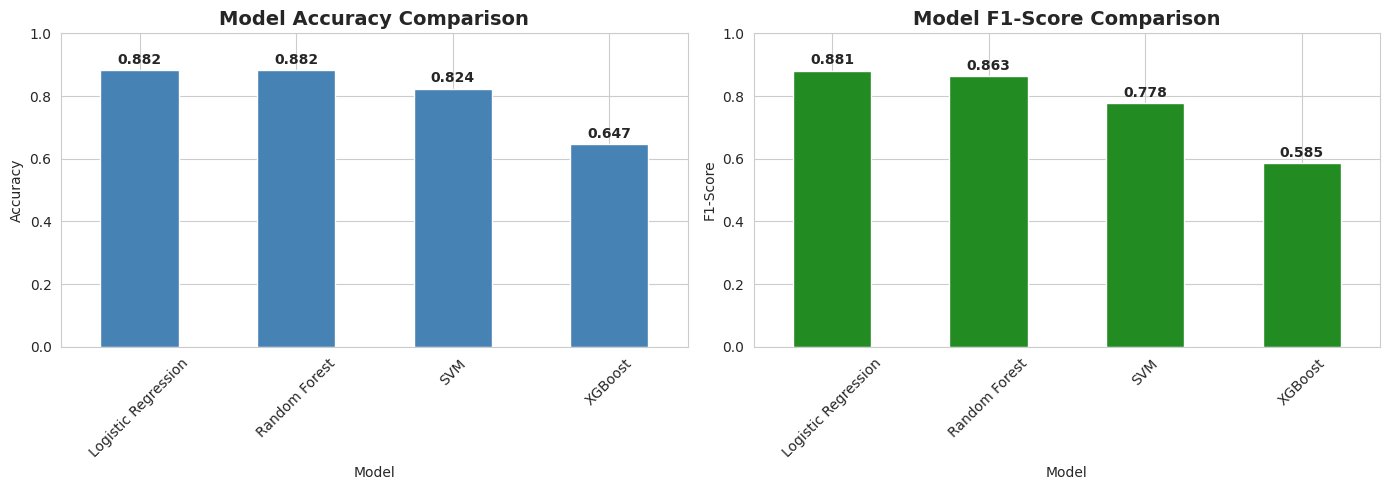

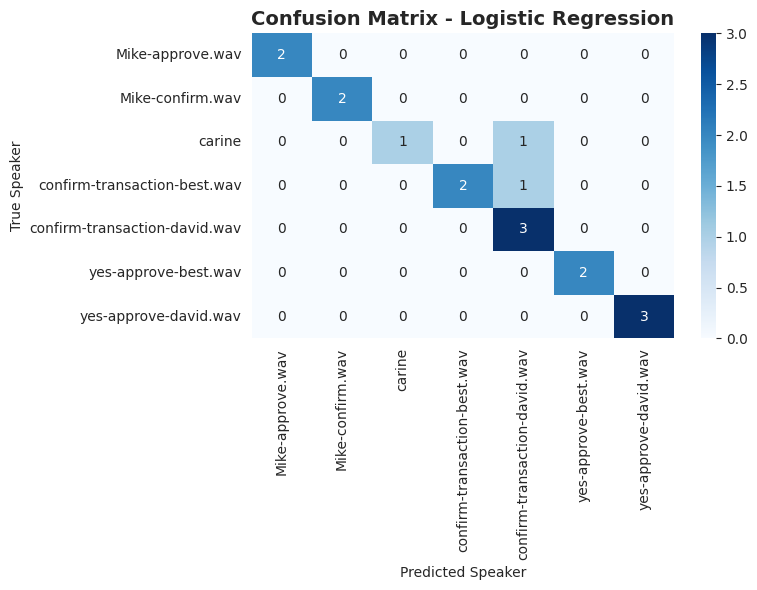

In [15]:
# Model comparison chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
comparison.plot(x='Model', y='Accuracy', kind='bar', ax=axes[0],
                color='steelblue', legend=False)
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim([0, 1])
axes[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison['Accuracy']):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# F1-Score comparison
comparison.plot(x='Model', y='F1-Score', kind='bar', ax=axes[1],
                color='forestgreen', legend=False)
axes[1].set_title('Model F1-Score Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('F1-Score')
axes[1].set_ylim([0, 1])
axes[1].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison['F1-Score']):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Confusion Matrix for best model
cm = confusion_matrix(y_test, results[best_model_name]['predictions'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_speaker.classes_,
            yticklabels=le_speaker.classes_)
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('True Speaker')
plt.xlabel('Predicted Speaker')
plt.tight_layout()
plt.show()



FEATURE IMPORTANCE

Random Forest - Top 15 Features:
   Feature  Importance
 feature_6    0.107754
  duration    0.085573
 feature_4    0.069968
 feature_2    0.067130
feature_27    0.064819
feature_13    0.058523
 feature_9    0.050758
 feature_3    0.046612
feature_22    0.038559
feature_11    0.038132
feature_14    0.038058
 feature_8    0.037574
feature_18    0.028860
 feature_5    0.024339
feature_17    0.021594


<Figure size 1000x600 with 0 Axes>

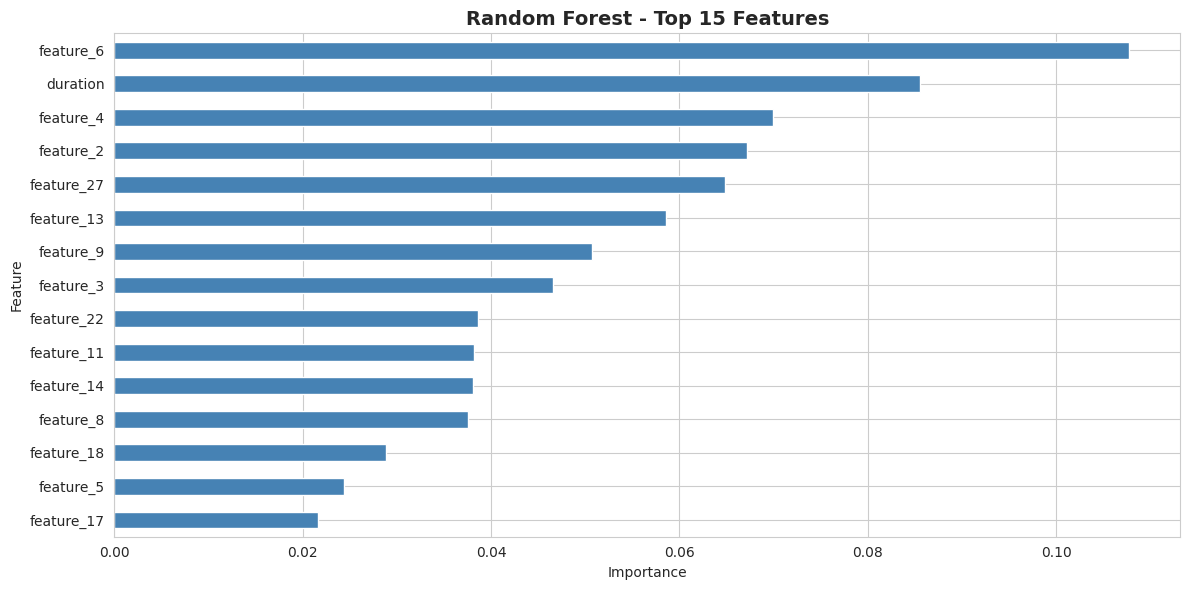

In [16]:
print("\n" + "="*70)
print("FEATURE IMPORTANCE")
print("="*70)

# For tree-based models
if 'Random Forest' in results:
    rf_model = results['Random Forest']['model']
    importance = pd.DataFrame({
        'Feature': all_features,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False).head(15)

    print("\nRandom Forest - Top 15 Features:")
    print(importance.to_string(index=False))

    plt.figure(figsize=(10, 6))
    importance.plot(x='Feature', y='Importance', kind='barh', legend=False, color='steelblue')
    plt.title('Random Forest - Top 15 Features', fontsize=14, fontweight='bold')
    plt.xlabel('Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()




In [17]:
print("\n" + "="*70)
print("SAVING MODEL & RESULTS")
print("="*70)

# Save the best model
best_model = results[best_model_name]['model']

with open('voiceprint_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print(f"✅ Model saved: voiceprint_model.pkl")

# Save speaker encoder
with open('speaker_encoder.pkl', 'wb') as f:
    pickle.dump(le_speaker, f)
print(f"✅ Encoder saved: speaker_encoder.pkl")

# Save scaler
with open('feature_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print(f"✅ Scaler saved: feature_scaler.pkl")



SAVING MODEL & RESULTS
✅ Model saved: voiceprint_model.pkl
✅ Encoder saved: speaker_encoder.pkl
✅ Scaler saved: feature_scaler.pkl
